# **Deep Learning Final Project**


This project aims to use four types of deep neural networks to partition the sound of heart auscultation in its four phases: S1, systole, S2 and Dyastole. 
The short time Fourier transform was used in data preprocessing.

The neural networks implemented include: Feedforward Neural Network, a Convolutional NN, a Recurrent NN and, finally, the Transformer.

Both the sequential (for FNN) and the functional (for the others) Keras API were used. 

Sofia Begonha Morgado

Junho.2022

## Import data and packages

In [ ]:
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns

#Import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Conv1D, Conv2D, MaxPooling2D, UpSampling1D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, Reshape, Input, TimeDistributed, LSTM

#### Mount drive 

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#import os
#os.chdir("/content/drive/MyDrive/ADNE_II/")

dir = './'
list_train_files = glob.glob(dir + "train/" + '*.npy')
list_val_files = glob.glob(dir + "val/" + '*.npy')
list_test_files = glob.glob(dir + "test/" + '*.npy')

data_train = tf.data.Dataset.from_tensor_slices(list_train_files)
data_val = tf.data.Dataset.from_tensor_slices(list_val_files)
data_test = tf.data.Dataset.from_tensor_slices(list_test_files)

print(list_train_files)
print(list_val_files)
print(list_test_files)

Mounted at /content/drive
['./train/49988_MV_sigTarg.npy', './train/49748_AV_2_sigTarg.npy', './train/85246_TV_sigTarg.npy', './train/84837_AV_sigTarg.npy', './train/69174_MV_sigTarg.npy', './train/69112_PV_sigTarg.npy', './train/85247_MV_sigTarg.npy', './train/84986_PV_sigTarg.npy', './train/49631_MV_sigTarg.npy', './train/50661_AV_sigTarg.npy', './train/69068_AV_sigTarg.npy', './train/51064_MV_sigTarg.npy', './train/49824_PV_sigTarg.npy', './train/50620_PV_sigTarg.npy', './train/84879_TV_sigTarg.npy', './train/49987_MV_sigTarg.npy', './train/84808_MV_sigTarg.npy', './train/50820_TV_sigTarg.npy', './train/84754_MV_sigTarg.npy', './train/50004_PV_sigTarg.npy', './train/84991_AV_sigTarg.npy', './train/50316_MV_sigTarg.npy', './train/85131_MV_sigTarg.npy', './train/84730_AV_sigTarg.npy', './train/50314_MV_sigTarg.npy', './train/50150_AV_sigTarg.npy', './train/84837_PV_sigTarg.npy', './train/50117_MV_sigTarg.npy', './train/49966_MV_sigTarg.npy', './train/49627_PV_sigTarg.npy', './train/84

#### Show data (unchanged datasets correspond to dataset, data_val e data_test)

In [ ]:
def read_npy(fname):
    """fname should be a npy file; função auxiliar que vai ser usada pela função 'map' para ler o conteúdo de cada um dos ficheiros do fnames_dataset e criar um novo dataset com estes conteúdos."""
    fname = fname.decode()
    recData = np.load(fname)
    return recData.astype(np.float32)

In [ ]:
data_train = data_train.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))
data_val = data_val.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))
data_test = data_test.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))

In [ ]:
it1 = iter(data_train)
ex1 = next(it1)
ex1

(<tf.Tensor: shape=(2, 12918), dtype=float32, numpy=
 array([[-276., -376.,  -85., ..., -215.,  163.,  249.],
        [   4.,    4.,    4., ...,    4.,    4.,    4.]], dtype=float32)>,)

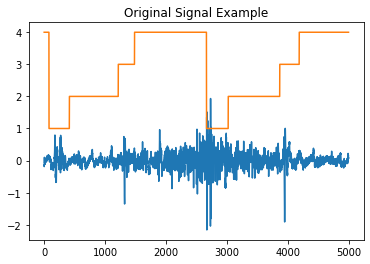

In [ ]:
import matplotlib.pyplot as plt
#Observar que temos tanto o traçado do som como tambem o classificador a laranja, correspondendo ao label

ex1[0].shape
aux=ex1[0]
plt.plot(aux[0,:5000]/2000)
plt.plot(aux[1,:5000])
plt.title("Original Signal Example")
plt.savefig("original_signal")

In [ ]:
#agora para ser mais facil, dpeois trocar
dataset = data_train

## **Feedforward neural network**

### **Prepare data**

#### Cut the samples for a constant lenght L

In [ ]:
#Define the length of the batches
L = 2000

#Cut in arrays with lenght L
data_cut = dataset.map(lambda x: x[:,:L]) 
data_val_cut = data_val.map(lambda x: x[:,:L]) 
data_test_cut = data_test.map(lambda x: x[:,:L]) 

print(data_cut)

<MapDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)>


Podemos ver o shape de cada um dos elementos do dataset usando um iterador

In [ ]:
it_cut = iter(data_cut)
ex_cut = next(it_cut)
ex_cut

<tf.Tensor: shape=(2, 2000), dtype=float32, numpy=
array([[-276., -376.,  -85., ...,   25.,   19., -236.],
       [   4.,    4.,    4., ...,    4.,    4.,    4.]], dtype=float32)>

#### Short Time Fourier Transform

In [ ]:
#Short time fourier transformation from tensorflow (aplicar TF a X[0] q é o sinal sonoro, x[1] é a segmentacao em S1, systole, S2, dyastole)
data_ft = data_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = 256, frame_step = 128)), x[1]))
data_val_ft = data_val_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = 256, frame_step = 128)), x[1]))
data_test_ft = data_test_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = 256, frame_step = 128)), x[1]))
print(data_ft)

<MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>


Iterate in order to visualize one example after the fourier transform

In [ ]:
it_f = iter(data_ft)
ex_f = next(it_f)
ex_f

(<tf.Tensor: shape=(14, 129), dtype=float32, numpy=
 array([[1.13544453e+04, 1.47983330e+04, 1.21872178e+04, ...,
         8.26697617e+01, 2.25963631e+01, 7.88745117e+01],
        [6.87491211e+03, 1.46625537e+04, 1.53082832e+04, ...,
         4.01879196e+01, 6.86449127e+01, 8.47297363e+01],
        [1.43247500e+04, 1.49637393e+04, 9.25513281e+03, ...,
         5.46355934e+01, 1.40522797e+02, 1.79258301e+02],
        ...,
        [1.02061836e+04, 1.47686631e+04, 9.62513770e+03, ...,
         1.22966110e+02, 1.99746948e+02, 1.69283691e+02],
        [1.39911353e+03, 1.37287295e+04, 1.27015537e+04, ...,
         1.27746185e+02, 1.05697289e+02, 2.44867554e+01],
        [1.27379834e+04, 4.85966455e+03, 4.01363867e+03, ...,
         4.95600090e+01, 3.60257950e+01, 1.19433594e+01]], dtype=float32)>,
 <tf.Tensor: shape=(2000,), dtype=float32, numpy=array([4., 4., 4., ..., 4., 4., 4.], dtype=float32)>)

Fazer plot dos dados

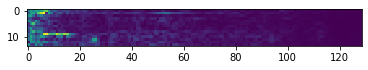

<Figure size 1080x1080 with 0 Axes>

In [ ]:
#Fazer plot de um exemplo após aplicada a transformada de Fourier
import matplotlib.pyplot as plt

plt.imshow(ex_f[0], interpolation="nearest")
plt.figure(figsize=(15,15))
plt.show
plt.savefig(fname = "Transf_fourier")

#### Produce batches to give to the network

In [ ]:
batch_size = 2
#so precisamos de batch n padded

dataset_input = data_ft.batch(batch_size)
dataset_val = data_val_ft.batch(batch_size)

it_i = iter(dataset_input)
ex_i = next(it_i)
ex_i

(<tf.Tensor: shape=(2, 14, 129), dtype=float32, numpy=
 array([[[1.13544453e+04, 1.47983330e+04, 1.21872178e+04, ...,
          8.26697617e+01, 2.25963631e+01, 7.88745117e+01],
         [6.87491211e+03, 1.46625537e+04, 1.53082832e+04, ...,
          4.01879196e+01, 6.86449127e+01, 8.47297363e+01],
         [1.43247500e+04, 1.49637393e+04, 9.25513281e+03, ...,
          5.46355934e+01, 1.40522797e+02, 1.79258301e+02],
         ...,
         [1.02061836e+04, 1.47686631e+04, 9.62513770e+03, ...,
          1.22966110e+02, 1.99746948e+02, 1.69283691e+02],
         [1.39911353e+03, 1.37287295e+04, 1.27015537e+04, ...,
          1.27746185e+02, 1.05697289e+02, 2.44867554e+01],
         [1.27379834e+04, 4.85966455e+03, 4.01363867e+03, ...,
          4.95600090e+01, 3.60257950e+01, 1.19433594e+01]],
 
        [[8.82767773e+03, 1.26558027e+04, 2.64658594e+04, ...,
          7.63118896e+01, 1.99245968e+01, 1.76469727e+01],
         [5.98505469e+04, 8.00914922e+04, 1.26805141e+05, ...,
          5

### **Define model**

In [ ]:
#Definir o modelo

def create_model():
    model = Sequential() #object of sequencial class
    model.add(Flatten(input_shape=(14, 129))) #shape do dataset_input (nao importa o numero de batches)

    #first dense layer 
    model.add(Dense(100)) 
    model.add(Activation("relu"))
    #model.add(BatchNormalization()) #do not use batch normalization after drop out, the rescaling will mess this!
    #model.add(Dropout(0.25)) #randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting 

    #output layer
    model.add(Dense(100)) 
    model.add(Activation("softmax"))

    model.add(Reshape((20, 5))) #4 classes + 1 (starts with 1, not 0)

    #Add upsampling layer in order to obtain one layer for each point
    model.add(UpSampling1D(100)) #10 a 100 parece razoavel

    return model


#Define parameters
NUM_EPOCHS = 1
INIT_LR  = 0.05
BS = 1 #batch size

optimizer = SGD(learning_rate=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
model = create_model()
model.summary()

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer, 
              metrics = tf.keras.metrics.SparseCategoricalAccuracy()) 

#Train the model with the data
history = model.fit(dataset_input,
                    validation_data= dataset_val,
                    batch_size=BS, 
                    epochs=NUM_EPOCHS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1806)              0         
                                                                 
 dense_1 (Dense)             (None, 100)               180700    
                                                                 
 activation_2 (Activation)   (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 activation_3 (Activation)   (None, 100)               0         
                                                                 
 reshape_2 (Reshape)         (None, 20, 5)             0         
                                                                 
 up_sampling1d_2 (UpSampling  (None, 2000, 5)          0

    epoch_list_ks  loss_function_ks  validation_loss_function_ks  accuracy_ks  \
0               1          1.065297                     1.035083     0.579330   
1               2          0.974330                     1.027452     0.616081   
2               3          0.972080                     0.998965     0.619631   
3               4          0.968587                     1.023874     0.614906   
4               5          0.964383                     1.023286     0.620381   
5               6          0.970480                     1.052592     0.619170   
6               7          0.971405                     1.036973     0.618313   
7               8          0.964214                     1.040789     0.622736   
8               9          0.964899                     1.036635     0.622562   
9              10          0.961824                     1.033938     0.621715   
10             11          0.960380                     1.210113     0.622884   
11             12          0

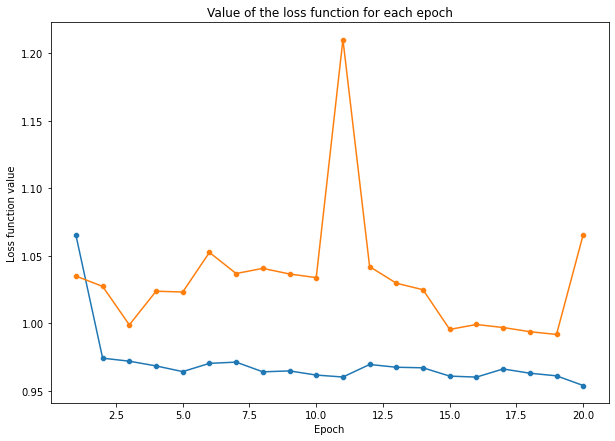

In [ ]:
#Plot the loss function for each epoch
data_ks = {"epoch_list_ks": np.arange(1, NUM_EPOCHS + 1, 1),
           "loss_function_ks": history.history["loss"],
           "validation_loss_function_ks": history.history["val_loss"],
           "accuracy_ks": history.history["sparse_categorical_accuracy"],
           "validation_accuracy_ks": history.history["val_sparse_categorical_accuracy"]}

#We create a dataframe so we can apreciate the evolution of the loss function through the epochs
df_ks = pd.DataFrame(data = data_ks)
#print(df_ks)


#Create a plot
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=df_ks, x='epoch_list_ks', y='loss_function_ks')
sns.lineplot(data=df_ks, x='epoch_list_ks', y='loss_function_ks')
sns.scatterplot(data=df_ks, x='epoch_list_ks', y='validation_loss_function_ks')
sns.lineplot(data=df_ks, x='epoch_list_ks', y='validation_loss_function_ks')
plt.title('Value of the loss function for each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss function value')
plt.show()

#loss0.954096      1.065810  acc  0.624923 val  0.665620 

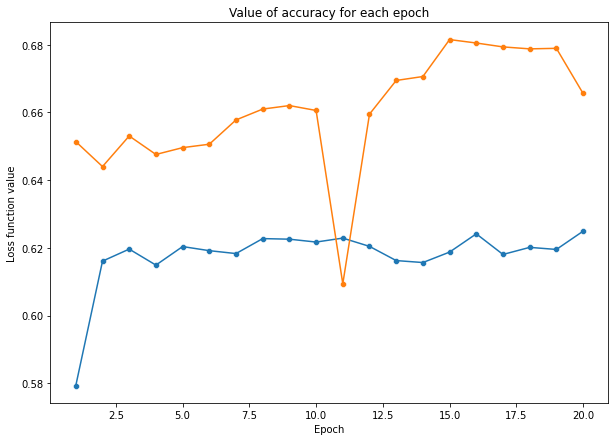

In [ ]:
#Plot the accuracy for each epoch
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=df_ks, x='epoch_list_ks', y='accuracy_ks')
sns.lineplot(data=df_ks, x='epoch_list_ks', y='accuracy_ks')
sns.scatterplot(data=df_ks, x='epoch_list_ks', y='validation_accuracy_ks')
sns.lineplot(data=df_ks, x='epoch_list_ks', y='validation_accuracy_ks')
plt.title('Value of accuracy for each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss function value')
plt.show()

In [ ]:
#Obtain Test Error: test set with batch size = 1
batch_size = 1
dataset_test_batch1 = data_test_ft.batch(batch_size)

results = model.evaluate(dataset_test_batch1, batch_size=1)
print("test loss, test acc:", results)

Evaluate on test data
286/286 [==============================] - 2s 7ms/step - loss: 2.2283 - sparse_categorical_accuracy: 0.0066
test loss, test acc: [2.228332042694092, 0.00661888113245368]


## **Convolutional Network**

### **Prepare data**

#### To use variable input size, one must add to the input data a variable corresponding to the size of each example

Create a tuple containing a tuple with the size of the example and the example after using the Fourier transform, and the label 

In [ ]:
data_size_var = dataset.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = 256, frame_step = 128))), x[1])) #length, signal after transform, label
data_size_var_val = data_val.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = 256, frame_step = 128))), x[1]))
data_size_var_test = data_test.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = 256, frame_step = 128))), x[1]))

it_i = iter(data_size_var)
ex_i = next(it_i)
ex_i

((<tf.Tensor: shape=(), dtype=int32, numpy=48560>,
  <tf.Tensor: shape=(378, 129), dtype=float32, numpy=
  array([[5.4247979e+03, 1.0581618e+04, 3.1296447e+04, ..., 9.0667572e+01,
          1.3317363e+02, 1.5744141e+01],
         [9.9289258e+03, 2.5343184e+04, 2.7663125e+04, ..., 9.9861763e+01,
          1.0942791e+02, 9.1986816e+01],
         [5.4744531e+03, 1.4697613e+04, 1.9480373e+04, ..., 1.1673839e+01,
          1.8089170e+01, 1.7250977e+01],
         ...,
         [8.9080234e+03, 5.8691289e+03, 2.6215288e+03, ..., 4.1781872e+01,
          5.0378407e+01, 3.3164062e+01],
         [5.6384058e+03, 4.8852505e+03, 6.8406304e+03, ..., 5.4874619e+01,
          7.0548264e+01, 1.3625049e+02],
         [1.0611468e+04, 7.5686021e+03, 1.8917529e+03, ..., 3.7145149e+01,
          5.9407978e+01, 3.2602539e+01]], dtype=float32)>),
 <tf.Tensor: shape=(48560,), dtype=float32, numpy=array([4., 4., 4., ..., 2., 2., 2.], dtype=float32)>)

In [ ]:
batch_size = 2
k = 129 #shape do x --> numero de frequencias que sai da STFT
dataset_input_variavel = data_size_var.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k])), [None])) #padded para a matriz ficar c o comprimento do exemplo maior exemplo e preenche tudo com 0s incluindo a label
dataset_input_variavel_val = data_size_var_val.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k])), [None]))
#No need to create batches of size 2 for the test set because we want to test one example at the time


it_i = iter(dataset_input_variavel)
ex_i = next(it_i)
ex_i

((<tf.Tensor: shape=(2,), dtype=int32, numpy=array([12918, 48400], dtype=int32)>,
  <tf.Tensor: shape=(2, 377, 129), dtype=float32, numpy=
  array([[[1.1354445e+04, 1.4798333e+04, 1.2187218e+04, ...,
           8.2669762e+01, 2.2596363e+01, 7.8874512e+01],
          [6.8749121e+03, 1.4662554e+04, 1.5308283e+04, ...,
           4.0187920e+01, 6.8644913e+01, 8.4729736e+01],
          [1.4324750e+04, 1.4963739e+04, 9.2551328e+03, ...,
           5.4635593e+01, 1.4052280e+02, 1.7925830e+02],
          ...,
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
  
         [[8.8276777e+03, 1.2655803e+04, 2.6465859e+04, ...,
           7.6311890e+01, 1.9924597e+01, 1.7646973e+01],
          [5.985

### **Define the model** using functional Keras

In [ ]:
inputs = Input(shape=(None,129),name='inputs')
inputs_L = Input(shape=[],name='inputs2')
layer_c = Conv1D(50, 1, padding="same")(inputs)
layer = Activation("relu")(layer_c)
layer = TimeDistributed(Dense(1500))(layer)
#layer = Flatten()(layer)
#layer = Dense(1500)(layer)
#adicionar mais layers cada uma com maxpooling e dropout
layer = Reshape((-1,5))(layer)
layer = UpSampling1D(size=10)(layer)
L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
output = layer[:,:L]

model_conv = Model(inputs = (inputs_L,inputs) , outputs=output)

#Define parameters
NUM_EPOCHS = 10
INIT_LR  = 0.1
BS = 1 #batch size

##### model_conv = Model(inputs = (inputs_L,inputs) , outputs = layer)
opt = SGD(learning_rate= INIT_LR , momentum=0.9)

model_conv.summary()

model_conv.compile(loss="sparse_categorical_crossentropy", optimizer=opt,metrics=["sparse_categorical_accuracy"])
history = model_conv.fit(dataset_input_variavel, 
                         validation_data= dataset_input_variavel_val,
                         batch_size=BS, 
                         epochs= NUM_EPOCHS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 129)]  0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, None, 50)     6500        ['inputs[0][0]']                 
                                                                                                  
 activation (Activation)        (None, None, 50)     0           ['conv1d[0][0]']                 
                                                                                                  
 time_distributed (TimeDistribu  (None, None, 1500)  76500       ['activation[0][0]']             
 ted)                                                                                         

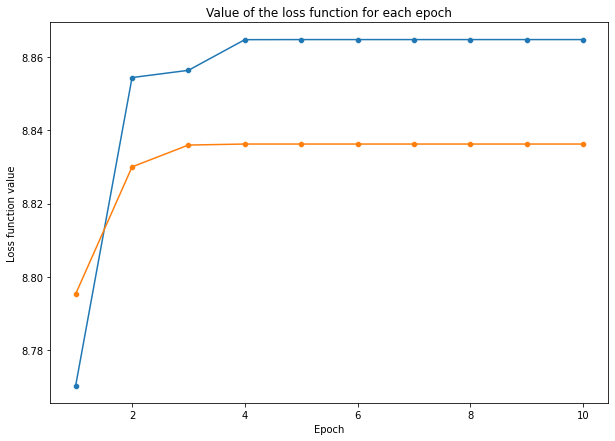

In [ ]:
#Plot the loss function for each epoch
data_ks = {"epoch_list_ks": np.arange(1, NUM_EPOCHS + 1, 1),
           "loss_function_ks": history.history["loss"],
           "validation_loss_function_ks": history.history["val_loss"],
           "accuracy_ks": history.history["sparse_categorical_accuracy"],
           "validation_accuracy_ks": history.history["val_sparse_categorical_accuracy"]}

#We create a dataframe so we can apreciate the evolution of the loss function through the epochs
df_ks = pd.DataFrame(data = data_ks)
#print(df_ks)


#Create a plot
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=df_ks, x='epoch_list_ks', y='loss_function_ks')
sns.lineplot(data=df_ks, x='epoch_list_ks', y='loss_function_ks')
sns.scatterplot(data=df_ks, x='epoch_list_ks', y='validation_loss_function_ks')
sns.lineplot(data=df_ks, x='epoch_list_ks', y='validation_loss_function_ks')
plt.title('Value of the loss function for each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss function value')
plt.show()

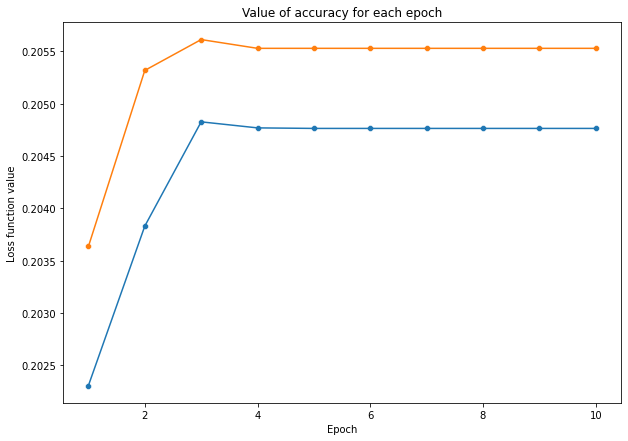

In [ ]:
#Plot the accuracy for each epoch
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=df_ks, x='epoch_list_ks', y='accuracy_ks')
sns.lineplot(data=df_ks, x='epoch_list_ks', y='accuracy_ks')
sns.scatterplot(data=df_ks, x='epoch_list_ks', y='validation_accuracy_ks')
sns.lineplot(data=df_ks, x='epoch_list_ks', y='validation_accuracy_ks')
plt.title('Value of accuracy for each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss function value')
plt.show()

In [ ]:
#Obtain Test Error: test set with batch size = 1
batch_size = 1
k = 129 
dataset_input_variavel_test_batch1 = data_size_var_test.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k])), [None]))

results = model_conv.evaluate(dataset_input_variavel_test_batch1 , batch_size=1)
print("test loss, test acc:", results)

Evaluate on test data
286/286 [==============================] - 12s 41ms/step - loss: 8.9438 - sparse_categorical_accuracy: 0.2020
test loss, test acc: [8.943769454956055, 0.20197996497154236]


## **Recurrent Network**

In [ ]:
inputs = Input(shape=(None,129),name='inputs')
inputs_L = Input(shape=[],name='inputs2')

layer= LSTM(50,return_sequences=True)(inputs)
layer= LSTM(50,return_sequences=True)(layer)
layer=Activation("relu")(layer)

layer = Reshape((-1,5))(layer)
layer = UpSampling1D(size=15)(layer)
L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
output = layer[:,:L]

model_recurrent = Model(inputs = (inputs_L,inputs) , outputs=output)

#Define parameters
NUM_EPOCHS = 1
INIT_LR  = 0.1
BS = 1 #batch size


opt = SGD(learning_rate=INIT_LR, momentum=0.9)

model_recurrent.summary()

model_recurrent.compile(loss="sparse_categorical_crossentropy", 
                        optimizer=opt,metrics=["sparse_categorical_accuracy"])

historyConv = model_recurrent.fit(dataset_input_variavel, 
                                  validation_data= dataset_input_variavel_val,
                                  batch_size=BS, 
                                  epochs= NUM_EPOCHS)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 129)]  0           []                               
                                                                                                  
 lstm (LSTM)                    (None, None, 50)     36000       ['inputs[0][0]']                 
                                                                                                  
 lstm_1 (LSTM)                  (None, None, 50)     20200       ['lstm[0][0]']                   
                                                                                                  
 activation_1 (Activation)      (None, None, 50)     0           ['lstm_1[0][0]']                 
                                                                                            

In [ ]:
it_i = iter(dataset_input_variavel)
ex_i = next(it_i)
ex_i

o = model_recurrent(ex_i[0])
print(o.shape)
print(ex_i[1].shape)

(2, 48400, 5)
(2, 48400)


In [ ]:
#Plot the loss function for each epoch
data_ks = {"epoch_list_ks": np.arange(1, NUM_EPOCHS + 1, 1),
           "loss_function_ks": history.history["loss"],
           "validation_loss_function_ks": history.history["val_loss"],
           "accuracy_ks": history.history["sparse_categorical_accuracy"],
           "validation_accuracy_ks": history.history["val_sparse_categorical_accuracy"]}

#We create a dataframe so we can apreciate the evolution of the loss function through the epochs
df_ks = pd.DataFrame(data = data_ks)
#print(df_ks)


#Create a plot
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=df_ks, x='epoch_list_ks', y='loss_function_ks')
sns.lineplot(data=df_ks, x='epoch_list_ks', y='loss_function_ks')
sns.scatterplot(data=df_ks, x='epoch_list_ks', y='validation_loss_function_ks')
sns.lineplot(data=df_ks, x='epoch_list_ks', y='validation_loss_function_ks')
plt.title('Value of the loss function for each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss function value')
plt.show()

ValueError: ignored

In [ ]:
#Plot the accuracy for each epoch
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=df_ks, x='epoch_list_ks', y='accuracy_ks')
sns.lineplot(data=df_ks, x='epoch_list_ks', y='accuracy_ks')
sns.scatterplot(data=df_ks, x='epoch_list_ks', y='validation_accuracy_ks')
sns.lineplot(data=df_ks, x='epoch_list_ks', y='validation_accuracy_ks')
plt.title('Value of accuracy for each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss function value')
plt.show()

In [ ]:
#Obtain Test Error: test set with batch size = 1 #ERORRR IF BATCH = 1!!!
print("Evaluate on test data")
results = model_recurrent.evaluate(dataset_input_variavel_test_batch1, batch_size=1)
print("test loss, test acc:", results)

## **Transformer**

In [ ]:
class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[1]
        batchS = tf.shape(x)[0]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        positions = tf.expand_dims(positions, axis = 0)
        positions = tf.repeat(positions, batchS, axis=0)
        return x + positions


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
inputs = keras.Input(shape=(None, 129))
inputs_L = Input(shape=[])
embDim = 10
newEmb = layers.TimeDistributed(layers.Dense(embDim))(inputs)

inputsPosEmb = PositionEmbedding(maxlen=50000, embed_dim=embDim)(newEmb)

transf1 = TransformerBlock(embed_dim=embDim,num_heads=3, ff_dim=8)(inputsPosEmb)
transf2 =TransformerBlock(embed_dim=embDim,num_heads=3, ff_dim=8)(transf1)
layer = layers.TimeDistributed(layers.Dense(1500))(transf2)
layer = Reshape((-1,5))(layer)
layer = UpSampling1D(size=15)(layer)
L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
output = layer[:,:L]

model_transf = keras.Model(inputs=(inputs_L, inputs), outputs=output)


#Define parameters
NUM_EPOCHS = 1
INIT_LR  = 0.1
BS = 1 #batch size

opt = SGD(learning_rate=INIT_LR, momentum=0.9)

model_transf.summary()

model_transf.compile(loss="sparse_categorical_crossentropy", 
                     optimizer=opt,metrics=["sparse_categorical_accuracy"])

history_transf = model_transf.fit(dataset_input_variavel, 
                                  validation_data= dataset_input_variavel_val,
                                  batch_size=BS, 
                                  epochs= NUM_EPOCHS)

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, 129)]  0           []                               
                                                                                                  
 time_distributed_18 (TimeDistr  (None, None, 10)    1300        ['input_7[0][0]']                
 ibuted)                                                                                          
                                                                                                  
 position_embedding_3 (Position  (None, None, 10)    500000      ['time_distributed_18[0][0]']    
 Embedding)                                                                                       
                                                                                           

KeyboardInterrupt: ignored

In [ ]:
it_i = iter(dataset_input_variavel)
ex_i = next(it_i)
ex_i


((<tf.Tensor: shape=(2,), dtype=int32, numpy=array([12918, 48400], dtype=int32)>,
  <tf.Tensor: shape=(2, 377, 129), dtype=float32, numpy=
  array([[[1.1354445e+04, 1.4798333e+04, 1.2187218e+04, ...,
           8.2669762e+01, 2.2596363e+01, 7.8874512e+01],
          [6.8749121e+03, 1.4662554e+04, 1.5308283e+04, ...,
           4.0187920e+01, 6.8644913e+01, 8.4729736e+01],
          [1.4324750e+04, 1.4963739e+04, 9.2551328e+03, ...,
           5.4635593e+01, 1.4052280e+02, 1.7925830e+02],
          ...,
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
  
         [[8.8276777e+03, 1.2655803e+04, 2.6465859e+04, ...,
           7.6311890e+01, 1.9924597e+01, 1.7646973e+01],
          [5.985

In [ ]:
o = model_transf(ex_i[0])
print(o.shape)
print(ex_i[1].shape)

(2, 48400, 5)
(2, 48400)


In [ ]:
#Plot the loss function for each epoch
data_ks = {"epoch_list_ks": np.arange(1, NUM_EPOCHS + 1, 1),
           "loss_function_ks": history.history["loss"],
           "validation_loss_function_ks": history.history["val_loss"],
           "accuracy_ks": history.history["sparse_categorical_accuracy"],
           "validation_accuracy_ks": history.history["val_sparse_categorical_accuracy"]}

#We create a dataframe so we can apreciate the evolution of the loss function through the epochs
df_ks = pd.DataFrame(data = data_ks)
#print(df_ks)


#Create a plot
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=df_ks, x='epoch_list_ks', y='loss_function_ks')
sns.lineplot(data=df_ks, x='epoch_list_ks', y='loss_function_ks')
sns.scatterplot(data=df_ks, x='epoch_list_ks', y='validation_loss_function_ks')
sns.lineplot(data=df_ks, x='epoch_list_ks', y='validation_loss_function_ks')
plt.title('Value of the loss function for each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss function value')
plt.show()

In [ ]:
#Plot the accuracy for each epoch
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=df_ks, x='epoch_list_ks', y='accuracy_ks')
sns.lineplot(data=df_ks, x='epoch_list_ks', y='accuracy_ks')
sns.scatterplot(data=df_ks, x='epoch_list_ks', y='validation_accuracy_ks')
sns.lineplot(data=df_ks, x='epoch_list_ks', y='validation_accuracy_ks')
plt.title('Value of accuracy for each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss function value')
plt.show()

In [ ]:
#Obtain Test Error: test set with batch size = 1 #ERORRR IF BATCH = 1!!!
print("Evaluate on test data")
results = model_tranf.evaluate(dataset_input_variavel_test_batch1, batch_size=1)
print("test loss, test acc:", results)